# Building an ARIMA Model for a Financial Dataset
<p> Modified by  Edwin Tembo <br>
    Source : https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/ai-for-finance/solution/arima_model.ipynb
</p>

In this notebook, you will build an ARIMA model for AAPL stock closing prices. The lab objectives are:

* Pull data from Google Cloud Storage into a Pandas dataframe
* Learn how to prepare raw stock closing data for an ARIMA model
* Apply the Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

In [ ]:
!pip install --user statsmodels

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Cloud Storage

In this section we'll read some ten years' worth of AAPL stock data into a Pandas dataframe. We want to modify the dataframe such that it represents a time series. This is achieved by setting the date as the index. 

In [ ]:
## USE PUBLIC gcs bucket or authenticate to GCP project first##
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

## Prepare data for ARIMA 

The first step in our preparation is to resample the data such that stock closing prices are aggregated on a weekly basis. 

In [3]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


Weekly returns. Take the log of the returns to normalize large fluctuations.

In [32]:
df_week['weekly_ret'] = np.log(df_week['close']).diff()
##df_week['weekly_ret'] = df_week['close'].diff()
df_week.head()

,close,weekly_ret
date,,
2009-06-21,19.525140,NaN
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396
2009-07-12,19.603160,-0.032905
2009-07-19,20.878880,0.063047


In [33]:
# drop null rows
df_week.dropna(inplace=True)

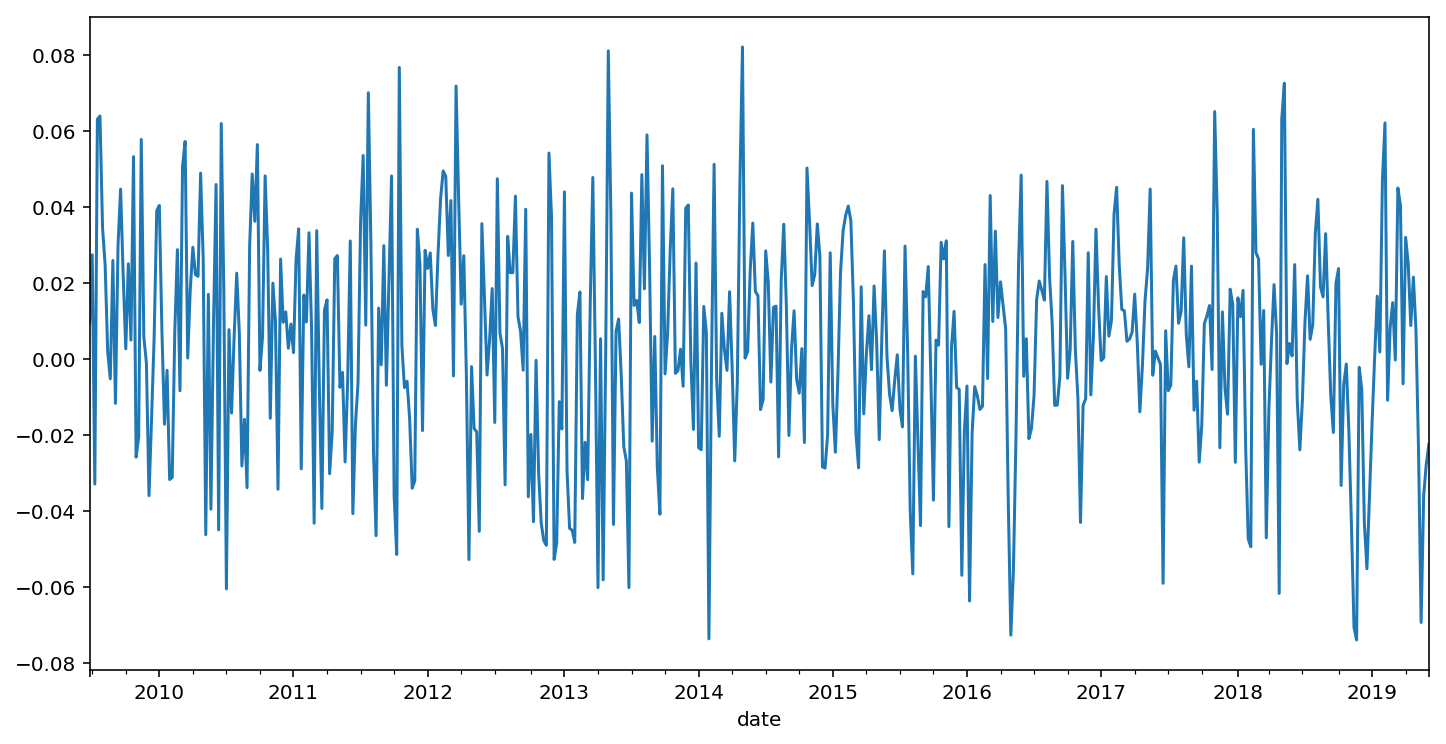

In [34]:
df_week.weekly_ret.plot(kind='line', figsize=(12, 6));

In [35]:
udiff = df_week.drop(['close'], axis=1)
udiff.head()

,weekly_ret
date,
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905
2009-07-19,0.063047
2009-07-26,0.063879


## Test for stationarity of the udiff series

Time series are stationary if they do not contain trends or seasonal swings. The Dickey-Fuller test can be used to test for stationarity. 

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [37]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

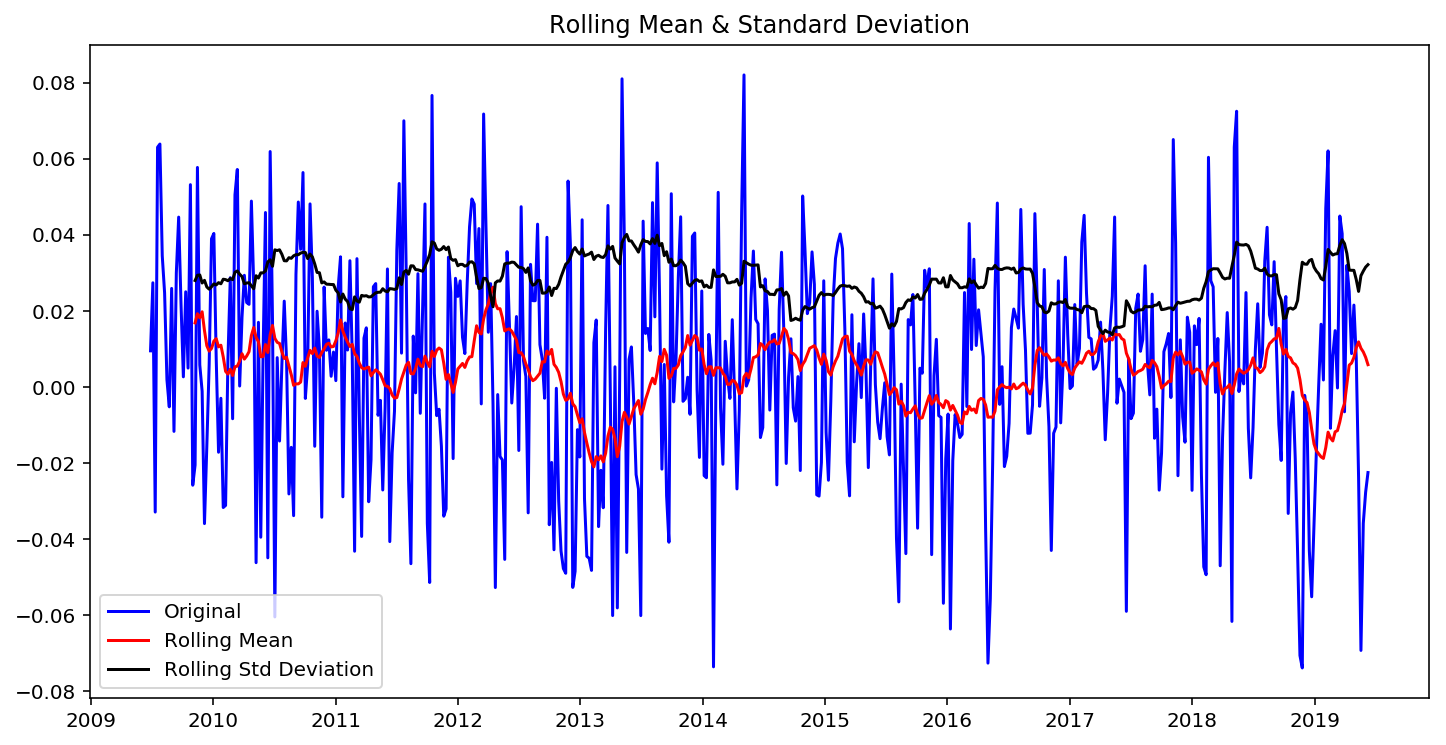

In [38]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [39]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.103358e+01
p-value                        5.589099e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.170000e+02
Critical Value (5%)           -2.867147e+00
Critical Value (1%)           -3.443062e+00
Critical Value (10%)          -2.569756e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypotehsis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts helps us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values.

The PACF is the partial correlation function that gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

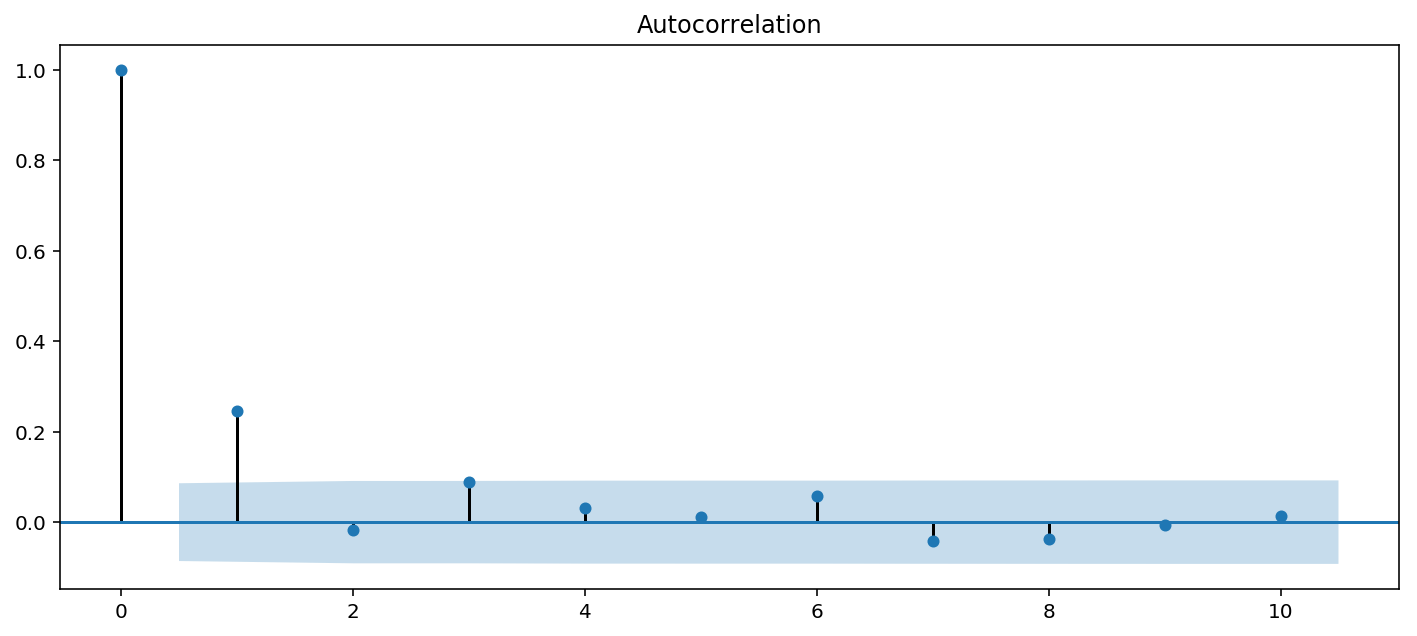

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

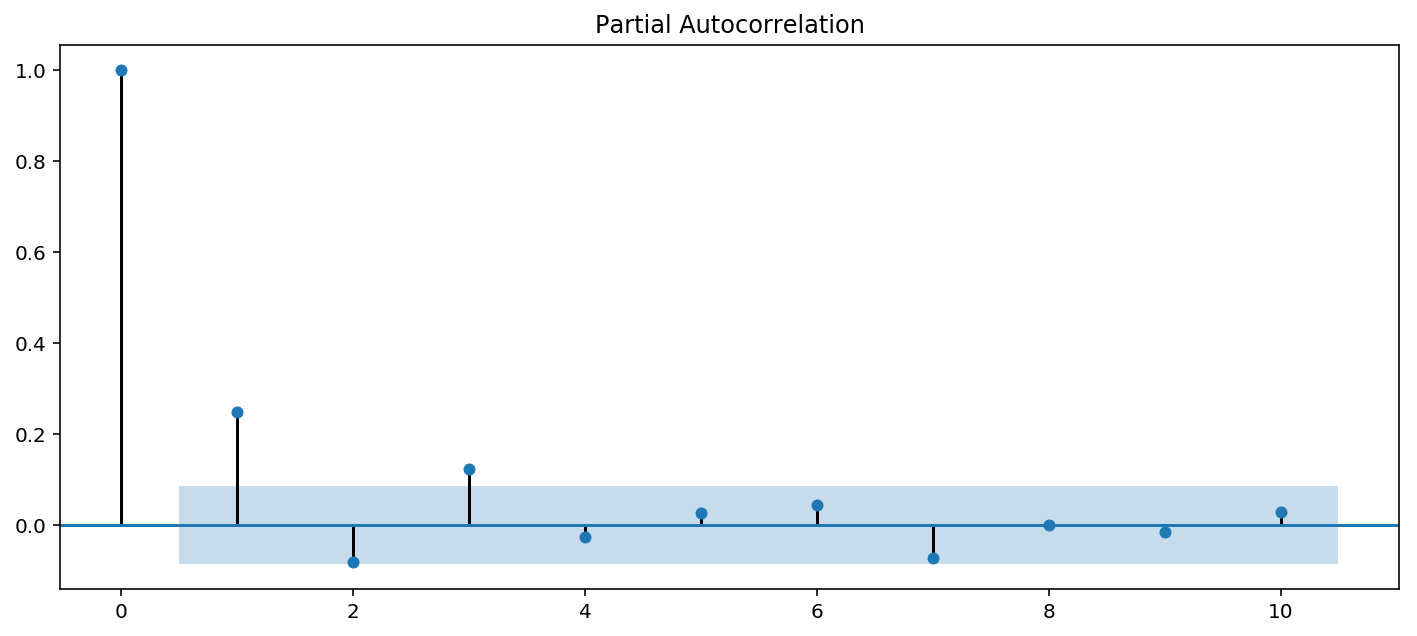

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

The table below summarizes the patterns of the ACF and PACF.

<img src="../imgs/How_to_Read_PACF_ACF.jpg" alt="drawing" width="300" height="300"/>

The above chart shows that reading PACF gives us a lag "p" = 3 and reading ACF gives us a lag "q" of 1. Let's Use Statsmodel's ARMA with those parameters to build a model. The way to evaluate the model is to look at AIC - see if it reduces or increases. The lower the AIC (i.e. the more negative it is), the better the model.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 

In [49]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (1, 1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:                     ARMA(1, 1)   Log Likelihood                1125.152
Method:                       css-mle   S.D. of innovations              0.028
Date:                Fri, 10 Apr 2020   AIC                          -2242.304
Time:                        01:44:52   BIC                          -2225.289
Sample:                             0   HQIC                         -2235.638
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      2.792      0.005       0.001       0.007
ar.L1.y       -0.2184      0.122     -1.784      0.075      -0.458       0.022
ma.L1.y        0.4983      0.107      4.638      0.000       0.288       0.709
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.5793           +0.0000j            4.5793            0.5000
MA.1           -2.0068           +0.0000j            2.0068            0.5000
-----------------------------------------------------------------------------
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys).

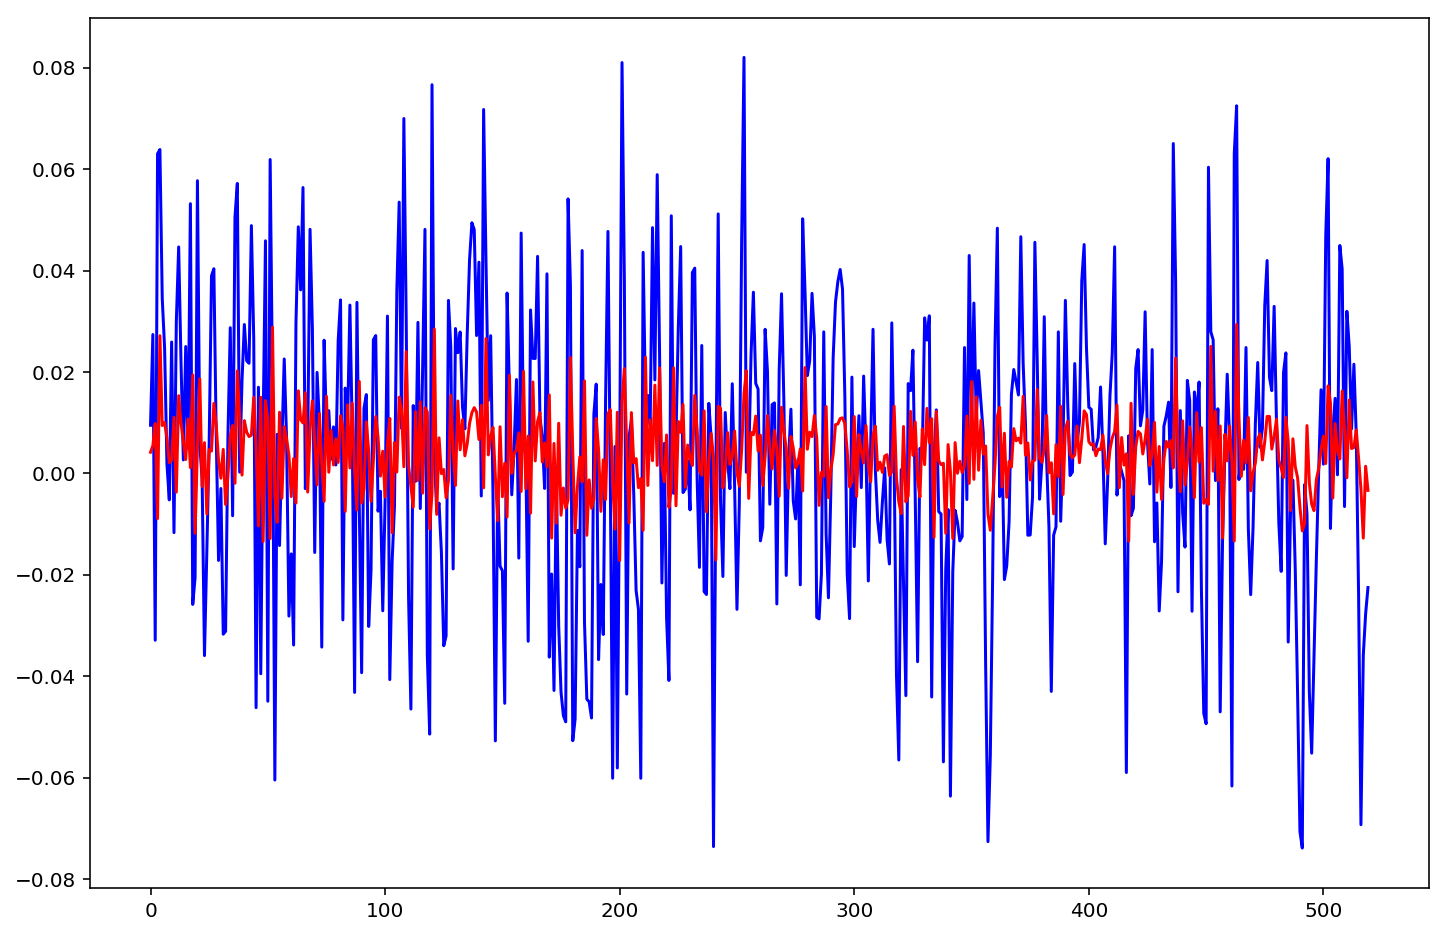

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

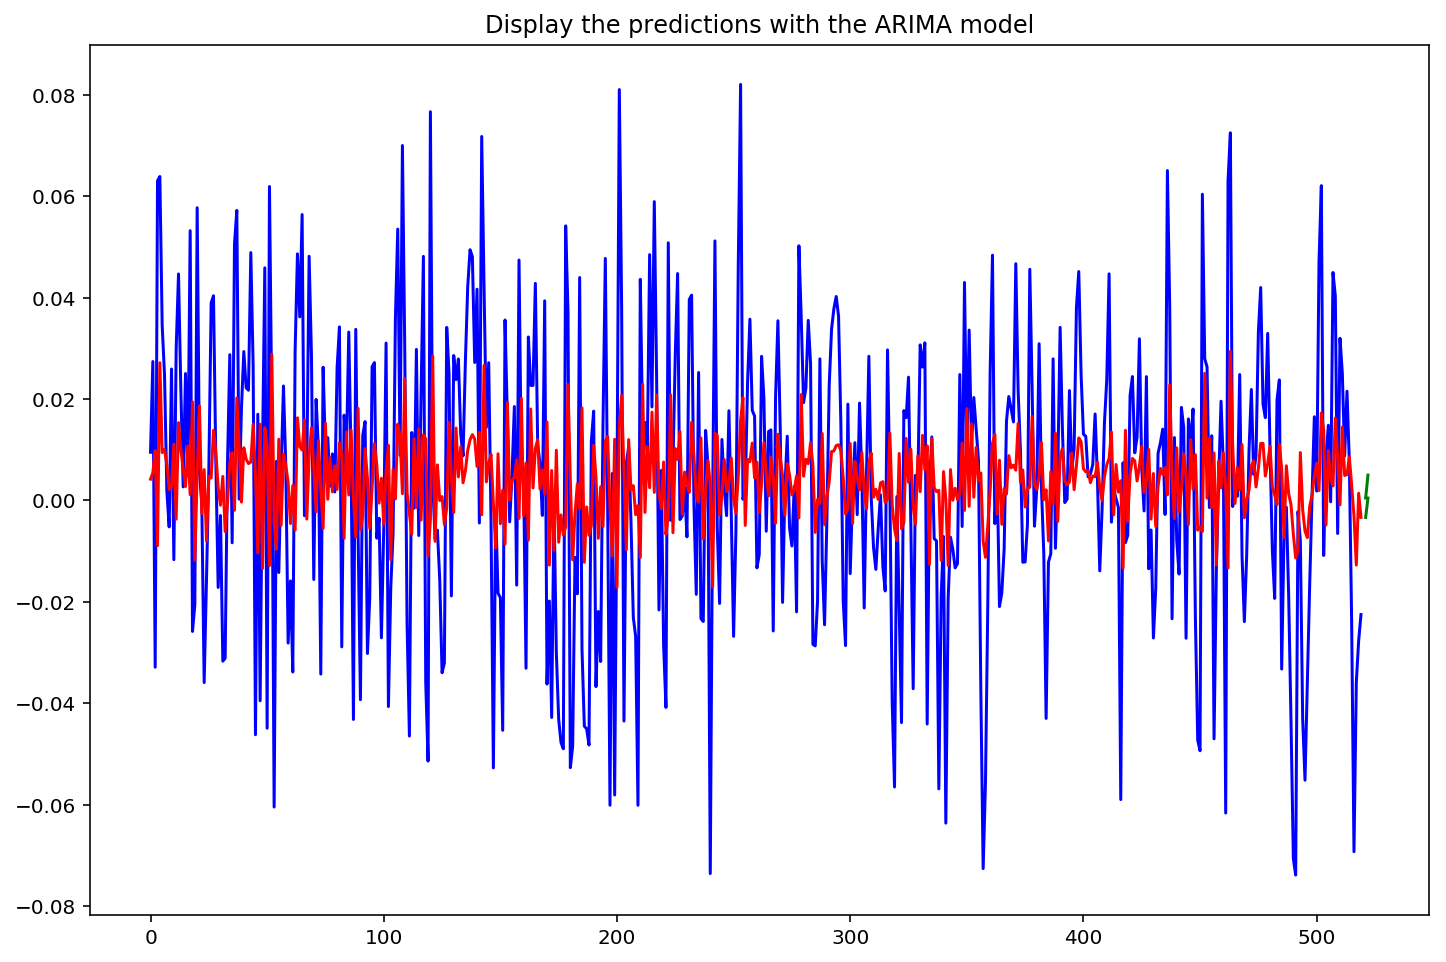

In [51]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if the hyper parameters are tuned, it may help improve the model.